# Data  Sampling

This notebook shows the basic data sampling algorithm we need. Unfortunatly I wasn't able to re-use too much of Ahmed's code from the `tuple_generator.py` file, but fortunatly, it is still pretty easy to implement, only a dozen or so lines of code. The basic idea is going to be to repeat the process outlined here for all the videos in the dataset. 

You should be able to copy and paste the code listings without many changes. If you want to re-run this notebook (which you might), then make sure `v_ApplyEyeMakeup_g01_c01.avi` (is in the dataset) is stored in the path you *run `jupyter` from*, otherwise it won't be able to find the video. Alternativly just replace the video path with something on your machine.

Starting with the imports (you can ignore line 1)

In [1]:
%matplotlib notebook

import utils
import imageio
import matplotlib
import numpy as np
import constants as const
import cv2

## Load Video

Loading the video is pretty simple with this library. You just give the path and tell it to use `ffmpeg`. This open the video for reading and allows you to get metadata, like frame counts, as well as grabbing frames at frame positions. Replace the file name in the first argument if you want to use a different video.

In [2]:
vid = imageio.get_reader('v_ApplyEyeMakeup_g01_c01.avi', 'ffmpeg')

## Select Frame Indices

Here's a quick algorithm to sample frame indices. Formally, all you do is, given a video with $f$ frames, sample $n$ integers uniformly without replacement from $[0,f)$.

First we print the total number of frames in the video, retrieved from the metadata.

In [3]:
n_frames = 12
total_frames = vid._meta['nframes']

print('Total Frames:', total_frames)

Total Frames: 164


164 frames is approximately 7 seconds of video. Next we use numpy to do the sampling and make sure to sort so that the frames are correctly ordered. The final result is the set of frame numbers which we will extract from next.

In [4]:
frames_idx = np.random.choice(range(total_frames), n_frames, replace=False)
frames_idx.sort()

print('Sampling Frames:', frames_idx)

Sampling Frames: [  7  16  32  37  72  74  78  87 131 141 147 153]


## Sample Frames

Now we can extract the frames, which is as simple as looping over them calling `vid.get_data()` to get the actual image. Ahmed defines a "nominal width and height" as $320 \times 480$ to which all images are resized, so we can take care of that now too using OpenCV. For now I store each frame separatly in a python list.

In [5]:
frames = []
for i in range(len(frames_idx)):
    f = vid.get_data(frames_idx[i])
    rf = cv2.resize(f, (const.nominal_width, const.nominal_height))
    frames.append(rf)

For fun, here is a visuzlization of the extracted frames (to prove it works I guess)

<IPython.core.display.Javascript object>


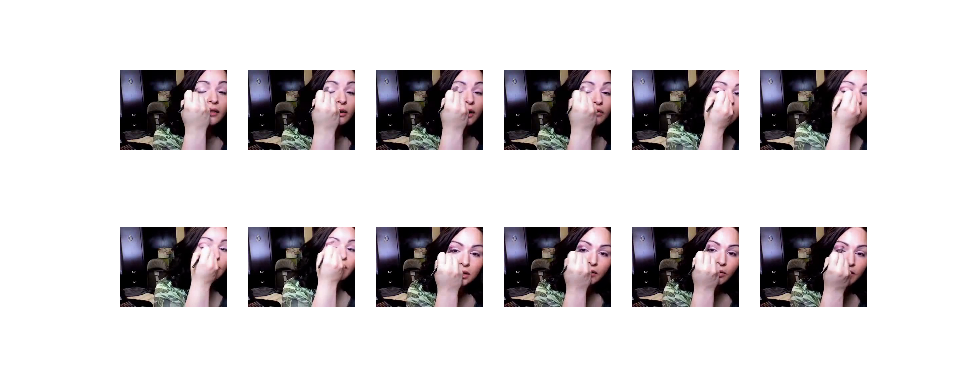

In [6]:
matplotlib.pyplot.figure()

for i in range(len(frames)):
    matplotlib.pyplot.subplot(2, n_frames / 2, i+1)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.imshow(frames[i])

## Build Stack of Difference

Ahmed's stack of difference is made by simply stacking the frames, each of which are $240 \times 320 \times 3$ rank-3 tensors into a single rank-4 tensor. In our case this gives a $240 \times 320 \times 3 \times 12$ tensor. Ahmed has a slightly more verbose way of doing this, but numpy has a one-liner so here it is. We might want to make this two $240 \times 320 \times 3 \times 6$ tensors (two stack-of-difference for each video), that's something we should discuss.

In [7]:
sod = np.stack(frames, 3)

## Pickle

Pickling is exactly what you would expect except that I use Ahmed's convenience function for it. Unpickling this file should give you back exactly the `sod` variable which you can use as needed.

In [8]:
utils.pkl_write('sample.pkl', sod)